MACHINE LEARNING MODEL FOR STOCKS RETURN PREDICTIONS BY FINANCIAL FUNDAMENTALS

Part 1: FINANCIAL FUNDAMENTALS SCRAPER

---


This first part of the project will be about getting the financial data almost automatically. 

**Needed accounts for the model.**






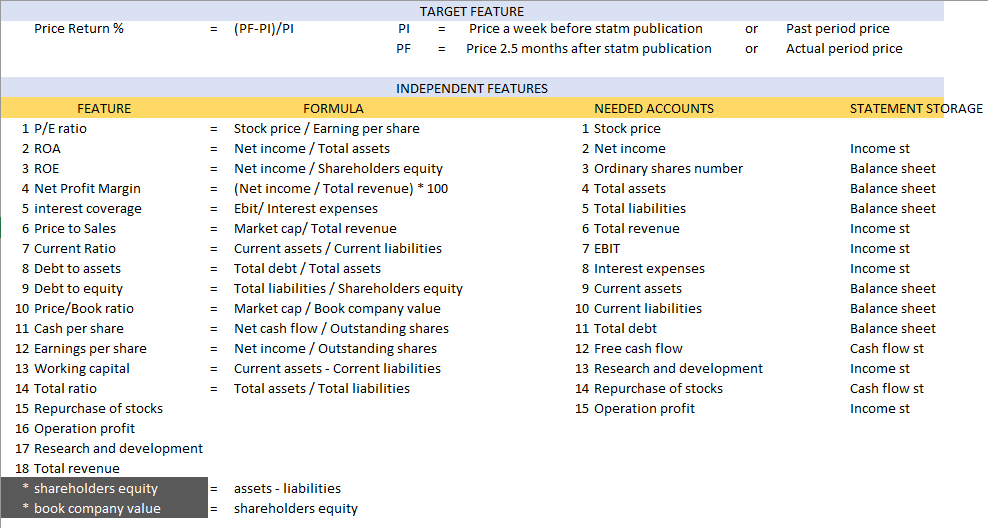

In [3]:
# Necessary libraries importing
import re
import json
import csv
from io import StringIO
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np

**Pending and ideas list:**
*   Consider to use an average of several days as final prices
*   Look for another method to append DF's to avoid drop NA's
*   IDK why x.drop works well at stmts joining but not with DF's concat.
*   Keep in mind would be more significant to calculate the return % by comparing period vs period (like all the features) instead of short term return rates.





In [ ]:
url_financials = 'https://finance.yahoo.com/quote/{}/financials?p={}' #Generic link

In [ ]:
# Function to scrape the three financial statements (Balance Sheet, income and Cash Flow Statements) at once
def main_scraper(stock):

      print('Attempting to scrape data for ' + stock)
      response = requests.get(url_financials.format(stock, stock)) 

      soup = BeautifulSoup(response.text, 'html.parser')
  
      pattern = re.compile(r'\s--\sData\s--\s')
      script_data = soup.find('script', text=pattern).contents[0]
      # beginning
      print(script_data[:500])
      # The end
      print(script_data[-500:])
      start = script_data.find("context")-2
      json_data = json.loads(script_data[start:-12])

  # Keys obtained from the code block above
      print(json_data['context'].keys())
      print(json_data['context']['dispatcher']['stores']['QuoteSummaryStore'].keys()) 

  # Existing keys for each annual and quarterly statement data
      annual_is = json_data['context']['dispatcher']['stores']['QuoteSummaryStore']['incomeStatementHistory']['incomeStatementHistory']
      quarterly_is = json_data['context']['dispatcher']['stores']['QuoteSummaryStore']['incomeStatementHistoryQuarterly']['incomeStatementHistory']

      annual_cf = json_data['context']['dispatcher']['stores']['QuoteSummaryStore']['cashflowStatementHistory']['cashflowStatements']
      quarterly_cf = json_data['context']['dispatcher']['stores']['QuoteSummaryStore']['cashflowStatementHistoryQuarterly']['cashflowStatements']

      annual_bs = json_data['context']['dispatcher']['stores']['QuoteSummaryStore']['balanceSheetHistory']['balanceSheetStatements']
      quarterly_bs = json_data['context']['dispatcher']['stores']['QuoteSummaryStore']['balanceSheetHistoryQuarterly']['balanceSheetStatements']

  # for loop to scrape and append each statement 
      annual_stmts = []
      all_st = [annual_is, annual_bs, annual_cf] 
      for each_st in all_st:
        for s in each_st:
            statement = {}
            for key, val in s.items():
                try:
                    statement[key] = val['raw']
                except TypeError:               # Error exception to skip Datatype mismatches
                      continue
                except KeyError:                # Error exception to skip missing keys
                      continue
            annual_stmts.append(statement)

  # Remove empty rows resulting from appending duplicated accounts adaptation
            app_raw_st = pd.DataFrame(annual_stmts)
            app_raw_st = app_raw_st.apply(lambda x: pd.Series(x.dropna().values))  
            app_raw_st = app_raw_st[:-8]
            app_raw_st.insert(0, 'stock', stock)
      return app_raw_st

In [ ]:
# Function for multiple stocks statements concatenation 
def main_scrape_multi(stocks):
    return pd.concat([main_scraper(stock) for stock in stocks], sort=False)

In [ ]:
# Space to code the IPO's date Scraper


In [ ]:
# Symbols input list for multiple scraping
stocks = ['MSFT', 'T', 'AAPL', 'AMD', 'GOOGL', 'AMZN', 'CSCO', 'KO', 'HD', 'HPE', 'INTC', 'MCD', 'NFLX', 'NVDA', 'QCOM', 'TMUS', 'WMT', 'TWTR', 'EBAY', 'FB', 'FDX', 'NOK', 'CVX', 'GM', 'HAS', 'HST', 'K', 'MET', 'MU', 'NKE', 'NLOK', 'ORCL', 'PEP', 'RL', 'SBUX', 'DIS', 'F', 'PBR', 'XOM', 'AAL', 'BA', 'SONY', 'SHOP', 'SAP', 'ADBE', 'TSM', 'BABA', 'AMX', 'VZ', 'SPG', 'INVH', 'CCI', 'LPL', 'FLEX', 'DBX', 'GDDY', 'PAGS', 'CRM', 'BIDU', 'CMCM', 'CX', 'TV', 'HERDEZ.MX', 'NTDOY']
main_df_combined = main_scrape_multi(stocks) #output saved into a dataframe

In [ ]:
# Partial selected accounts to calculte the financial ratios (There are three missing accounts that weren't possible to scrape with beautiful soup 
# but are enabled to scrape with LXML method used later)
main_df_combined = main_df_combined[['stock', 'endDate', 'netIncome', 'totalRevenue', 'ebit', 'researchDevelopment', 'operatingIncome', 'interestExpense', 'totalAssets', 'totalLiab', 'totalCurrentLiabilities', 'totalCurrentAssets', 'repurchaseOfStock']]
main_df_combined

,stock,endDate,netIncome,totalRevenue,ebit,researchDevelopment,operatingIncome,interestExpense,totalAssets,totalLiab,totalCurrentLiabilities,totalCurrentAssets,repurchaseOfStock
0,MSFT,1593475200,4.428100e+10,1.430150e+11,5.295900e+10,1.926900e+10,5.295900e+10,-2.591000e+09,3.013110e+11,1.830070e+11,7.231000e+10,1.819150e+11,-2.296800e+10
1,MSFT,1561852800,3.924000e+10,1.258430e+11,4.295900e+10,1.687600e+10,4.295900e+10,-2.686000e+09,2.865560e+11,1.842260e+11,6.942000e+10,1.755520e+11,-1.954300e+10
2,MSFT,1530316800,1.657100e+10,1.103600e+11,3.505800e+10,1.472600e+10,3.505800e+10,-2.733000e+09,2.588480e+11,1.761300e+11,5.848800e+10,1.696620e+11,-1.072100e+10
3,MSFT,1498780800,2.548900e+10,9.657100e+10,2.933100e+10,1.303700e+10,2.933100e+10,-2.222000e+09,2.503120e+11,1.626010e+11,5.574500e+10,1.626960e+11,-1.178800e+10
0,T,1609372800,-5.176000e+09,1.717600e+11,2.565600e+10,NaN,2.565600e+10,-7.925000e+09,5.257610e+11,3.465210e+11,6.343800e+10,5.200800e+10,-5.498000e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,HERDEZ.MX,1514678400,1.046111e+09,2.006492e+10,2.812898e+09,NaN,2.812898e+09,-5.734910e+08,2.784602e+10,1.050422e+10,3.123141e+09,8.254989e+09,-1.551190e+08
0,NTDOY,1585612800,2.586410e+11,1.308519e+12,3.523710e+11,8.412700e+10,3.523710e+11,NaN,1.934087e+12,3.931870e+11,3.556830e+11,1.501583e+12,-4.300000e+07
1,NTDOY,1553990400,1.940090e+11,1.200560e+12,2.497020e+11,6.962400e+10,2.497020e+11,NaN,1.690304e+12,2.755060e+11,2.450090e+11,1.344972e+12,-3.103800e+10
2,NTDOY,1522454400,1.395900e+11,1.055682e+12,1.775580e+11,6.399900e+10,1.775580e+11,NaN,1.633748e+12,3.101730e+11,2.780760e+11,1.276764e+12,-7.800000e+07


In [ ]:
main_df_combined.isna().sum().head(60) # Missing values (researchDevelpment and repurcheseofStock empty rows doesn't affect the model because the features will pass as "0% increase")

stock                        0
endDate                      0
netIncome                    0
totalRevenue                 0
ebit                         0
researchDevelopment        120
operatingIncome              0
interestExpense              9
totalAssets                  0
totalLiab                    0
totalCurrentLiabilities      0
totalCurrentAssets           0
repurchaseOfStock           44
dtype: int64


---
**TARGET FEATURE SELECTION:** % stock price return given several ratios changes % (independent features)

---

There are at least two options to establish the Label:
1.   Change % directly betweeen the prices at statements publication date (actually 2.5 months after), giving a yearly rate return. (Just like the rest variables)
2.   Change % between the price 10 days before yearly statements closing and the price 2.5 months after yearly statements closing.


 

**STOCK PRICES SCRAPER**

---


In order to build the target label will scrape the price of each stock(x) at each year(y). Considering companies have chance to present their statements until 2 months after date, it would be needed to take the price 2.5 months after the yearly statements closing. That price will be compared with the price 10 day before the yearly statement closing.

That way the pre-presentation especulation and quarterly reports effect could be avoided.

In [ ]:
# Function for historical price scraping, adding date ranges and daily interval.
initial_prices = []
for row in range(len(main_df_combined)):           # for loop to apply scraper to each stock at each period.

  try:
    per0 = main_df_combined.iloc[row, 1] 
    startperiod = per0 - 1123200                   # 13 days before statms ending period (not necesarilly presentation date)
    FinDate = startperiod + 864000                 # 10 days range to scrape, selecting just the first price
    stockrow_init = main_df_combined.iloc[row, 0]  # Stock symbol variable
    
    stock_url = 'https://query1.finance.yahoo.com/v7/finance/download/{}?' # Generic Link
    params = {                                     # Request Parameters                 
        'period1':startperiod,
        'period2':FinDate,
        'interval':'1d',
        'events':'history'
    }

    
    response = requests.get(stock_url.format(stockrow_init), params=params)

    response.text

    file = StringIO(response.text)
    reader = csv.reader(file)
    data = list(reader)

    initial_price = data[1][4]               # Older date choosen between the rest of the 10 days range prices
    initial_prices.append(initial_price)     # List construction appending loop outputs
  except IndexError:                         # Error exception for recent statms publications (2.5 months or less ago) or 
    initial_price = 0
    initial_prices.append(initial_price)

  # Reasons for this code to output error: 
  # 1.- Stock's last statements presentation 2.5 months or less ago
  # 2.- stocks younger than 4 years being public because there are old fundamentals data but not prices.

In [ ]:
initial_prices

['194.240005',
 '132.850006',
 '100.860001',
 '70.870003',
 '29.400000',
 '38.740002',
 '29.750000',
 '38.459999',
 '115.360001',
 '54.974998',
 '54.470001',
 '39.667500',
 '94.779999',
 '42.349998',
 '18.830000',
 '10.980000',
 '1726.219971',
 '1351.910034',
 '1043.410034',
 '1085.089966',
 '3201.649902',
 '1784.030029',
 '1551.479980',
 '1190.579956',
 '45.930000',
 '58.049999',
 '42.500000',
 '31.500000',
 '53.740002',
 '53.910000',
 '48.320000',
 '45.930000',
 '273.190002',
 '232.949997',
 '177.110001',
 '196.309998',
 '9.350000',
 '15.350000',
 '15.330000',
 '14.700000',
 '50.470001',
 '57.700001',
 '47.080002',
 '46.259998',
 '215.080002',
 '195.630005',
 '179.710007',
 '174.199997',
 '534.450012',
 '320.799988',
 '270.940002',
 '190.419998',
 '521.010010',
 '251.979996',
 '150.440002',
 '220.110001',
 '113.459999',
 '78.040001',
 '73.239998',
 '50.570000',
 '131.919998',
 '76.309998',
 '64.779999',
 '63.470001',
 '143.389999',
 '115.589996',
 '97.730003',
 '104.300003',
 '55.869

In [ ]:
final_prices = []

for row in range(len(main_df_combined)):

      try: 
        period0 = main_df_combined.iloc[row, 1] 
        startDate = period0 + 6652800 # 77 days after quarter ending (not necessary statms presentation date)
        EndDate = startDate + 864000  # 10 days range to scrape, selecting just the first price.
        stockrow_fn = main_df_combined.iloc[row, 0] 
        
# Same stuff than Initial prices scraper.
        stock_url = 'https://query1.finance.yahoo.com/v7/finance/download/{}?'
        params = {
            'period1':startDate,
            'period2':EndDate,
            'interval':'1d',
            'events':'history'
        }

        response = requests.get(stock_url.format(stockrow_fn), params=params)
        response.text

        file = StringIO(response.text)
        reader = csv.reader(file)
        data = list(reader)

        final_price = data[1][4]
        final_prices.append(final_price)
      except IndexError:
        final_price = 0
        final_prices.append(final_price)
        
  # Reasons for this code to output error: 
  # 1.- Stock's last statements presentation 2.5 months or less ago
  # 2.- stocks younger than 4 years being public

In [ ]:
final_prices

['208.779999',
 '136.330002',
 '112.139999',
 '75.309998',
 '30.010000',
 '33.740002',
 '30.799999',
 '36.580002',
 '121.779999',
 '69.964996',
 '40.985001',
 '44.105000',
 '82.500000',
 '38.709999',
 '23.250000',
 '11.430000',
 '2021.339966',
 '1118.060059',
 '1188.550049',
 '1100.069946',
 '3027.989990',
 '1807.839966',
 '1742.150024',
 '1544.930054',
 '40.360001',
 '46.049999',
 '44.669998',
 '33.540001',
 '50.570000',
 '47.180000',
 '45.410000',
 '43.259998',
 '326.850006',
 '206.050003',
 '204.779999',
 '174.429993',
 '12.310000',
 '15.770000',
 '14.320000',
 '15.810000',
 '63.790001',
 '44.610001',
 '54.099998',
 '50.830002',
 '222.899994',
 '147.619995',
 '183.949997',
 '159.009995',
 '504.790009',
 '319.750000',
 '363.440002',
 '313.480011',
 '614.469971',
 '269.850006',
 '184.699997',
 '231.490005',
 '146.289993',
 '88.430000',
 '57.000000',
 '65.180000',
 '124.910004',
 '78.349998',
 '73.680000',
 '63.220001',
 '139.710007',
 '132.119995',
 '103.180000',
 '87.570000',
 '66.72

In [ ]:
# New columns creation by adding the lists generated.
main_df_combined['Initial Prices'] = np.asarray(initial_prices).flatten()
main_df_combined['Final Prices'] = np.asarray(final_prices).flatten()
main_df_combined

,stock,endDate,netIncome,totalRevenue,ebit,researchDevelopment,operatingIncome,interestExpense,totalAssets,totalLiab,totalCurrentLiabilities,totalCurrentAssets,repurchaseOfStock,Initial Prices,Final Prices
0,MSFT,1593475200,4.428100e+10,1.430150e+11,5.295900e+10,1.926900e+10,5.295900e+10,-2.591000e+09,3.013110e+11,1.830070e+11,7.231000e+10,1.819150e+11,-2.296800e+10,194.240005,208.779999
1,MSFT,1561852800,3.924000e+10,1.258430e+11,4.295900e+10,1.687600e+10,4.295900e+10,-2.686000e+09,2.865560e+11,1.842260e+11,6.942000e+10,1.755520e+11,-1.954300e+10,132.850006,136.330002
2,MSFT,1530316800,1.657100e+10,1.103600e+11,3.505800e+10,1.472600e+10,3.505800e+10,-2.733000e+09,2.588480e+11,1.761300e+11,5.848800e+10,1.696620e+11,-1.072100e+10,100.860001,112.139999
3,MSFT,1498780800,2.548900e+10,9.657100e+10,2.933100e+10,1.303700e+10,2.933100e+10,-2.222000e+09,2.503120e+11,1.626010e+11,5.574500e+10,1.626960e+11,-1.178800e+10,70.870003,75.309998
0,T,1609372800,-5.176000e+09,1.717600e+11,2.565600e+10,NaN,2.565600e+10,-7.925000e+09,5.257610e+11,3.465210e+11,6.343800e+10,5.200800e+10,-5.498000e+09,29.400000,30.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,HERDEZ.MX,1514678400,1.046111e+09,2.006492e+10,2.812898e+09,NaN,2.812898e+09,-5.734910e+08,2.784602e+10,1.050422e+10,3.123141e+09,8.254989e+09,-1.551190e+08,45.730000,46.980000
0,NTDOY,1585612800,2.586410e+11,1.308519e+12,3.523710e+11,8.412700e+10,3.523710e+11,NaN,1.934087e+12,3.931870e+11,3.556830e+11,1.501583e+12,-4.300000e+07,40.709999,55.700001
1,NTDOY,1553990400,1.940090e+11,1.200560e+12,2.497020e+11,6.962400e+10,2.497020e+11,NaN,1.690304e+12,2.755060e+11,2.450090e+11,1.344972e+12,-3.103800e+10,35.889999,43.180000
2,NTDOY,1522454400,1.395900e+11,1.055682e+12,1.775580e+11,6.399900e+10,1.775580e+11,NaN,1.633748e+12,3.101730e+11,2.780760e+11,1.276764e+12,-7.800000e+07,56.400002,41.650002


**Converting Date Format**

---
Once the initial and final prices are obtained it's adequate to convert time seconds format into date format.


In [ ]:
# Dataframe new version for manipulations making
df = main_df_combined
df_enddate = df['endDate']
df_enddate

0    1593475200
1    1561852800
2    1530316800
3    1498780800
0    1609372800
        ...    
3    1514678400
0    1585612800
1    1553990400
2    1522454400
3    1490918400
Name: endDate, Length: 256, dtype: int64

In [ ]:
df

,stock,endDate,netIncome,totalRevenue,ebit,researchDevelopment,operatingIncome,interestExpense,totalAssets,totalLiab,totalCurrentLiabilities,totalCurrentAssets,repurchaseOfStock,Initial Prices,Final Prices
0,MSFT,1593475200,4.428100e+10,1.430150e+11,5.295900e+10,1.926900e+10,5.295900e+10,-2.591000e+09,3.013110e+11,1.830070e+11,7.231000e+10,1.819150e+11,-2.296800e+10,194.240005,208.779999
1,MSFT,1561852800,3.924000e+10,1.258430e+11,4.295900e+10,1.687600e+10,4.295900e+10,-2.686000e+09,2.865560e+11,1.842260e+11,6.942000e+10,1.755520e+11,-1.954300e+10,132.850006,136.330002
2,MSFT,1530316800,1.657100e+10,1.103600e+11,3.505800e+10,1.472600e+10,3.505800e+10,-2.733000e+09,2.588480e+11,1.761300e+11,5.848800e+10,1.696620e+11,-1.072100e+10,100.860001,112.139999
3,MSFT,1498780800,2.548900e+10,9.657100e+10,2.933100e+10,1.303700e+10,2.933100e+10,-2.222000e+09,2.503120e+11,1.626010e+11,5.574500e+10,1.626960e+11,-1.178800e+10,70.870003,75.309998
0,T,1609372800,-5.176000e+09,1.717600e+11,2.565600e+10,NaN,2.565600e+10,-7.925000e+09,5.257610e+11,3.465210e+11,6.343800e+10,5.200800e+10,-5.498000e+09,29.400000,30.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,HERDEZ.MX,1514678400,1.046111e+09,2.006492e+10,2.812898e+09,NaN,2.812898e+09,-5.734910e+08,2.784602e+10,1.050422e+10,3.123141e+09,8.254989e+09,-1.551190e+08,45.730000,46.980000
0,NTDOY,1585612800,2.586410e+11,1.308519e+12,3.523710e+11,8.412700e+10,3.523710e+11,NaN,1.934087e+12,3.931870e+11,3.556830e+11,1.501583e+12,-4.300000e+07,40.709999,55.700001
1,NTDOY,1553990400,1.940090e+11,1.200560e+12,2.497020e+11,6.962400e+10,2.497020e+11,NaN,1.690304e+12,2.755060e+11,2.450090e+11,1.344972e+12,-3.103800e+10,35.889999,43.180000
2,NTDOY,1522454400,1.395900e+11,1.055682e+12,1.775580e+11,6.399900e+10,1.775580e+11,NaN,1.633748e+12,3.101730e+11,2.780760e+11,1.276764e+12,-7.800000e+07,56.400002,41.650002


In [ ]:
# For loop to convert each date row by using datatime library.
import datetime
new_date_col = []
for D in df_enddate:

    timestamp = datetime.datetime.fromtimestamp(D)
    date_format = timestamp.strftime('%Y-%m-%d')
    new_date_col.append(date_format)

In [ ]:
new_date_col

In [ ]:
# endDate column replaced by generated list 
df['endDate'] = new_date_col
df

,stock,endDate,netIncome,totalRevenue,ebit,researchDevelopment,operatingIncome,interestExpense,totalAssets,totalLiab,totalCurrentLiabilities,totalCurrentAssets,repurchaseOfStock,Initial Prices,Final Prices
0,MSFT,2020-06-30,4.428100e+10,1.430150e+11,5.295900e+10,1.926900e+10,5.295900e+10,-2.591000e+09,3.013110e+11,1.830070e+11,7.231000e+10,1.819150e+11,-2.296800e+10,194.240005,208.779999
1,MSFT,2019-06-30,3.924000e+10,1.258430e+11,4.295900e+10,1.687600e+10,4.295900e+10,-2.686000e+09,2.865560e+11,1.842260e+11,6.942000e+10,1.755520e+11,-1.954300e+10,132.850006,136.330002
2,MSFT,2018-06-30,1.657100e+10,1.103600e+11,3.505800e+10,1.472600e+10,3.505800e+10,-2.733000e+09,2.588480e+11,1.761300e+11,5.848800e+10,1.696620e+11,-1.072100e+10,100.860001,112.139999
3,MSFT,2017-06-30,2.548900e+10,9.657100e+10,2.933100e+10,1.303700e+10,2.933100e+10,-2.222000e+09,2.503120e+11,1.626010e+11,5.574500e+10,1.626960e+11,-1.178800e+10,70.870003,75.309998
0,T,2020-12-31,-5.176000e+09,1.717600e+11,2.565600e+10,NaN,2.565600e+10,-7.925000e+09,5.257610e+11,3.465210e+11,6.343800e+10,5.200800e+10,-5.498000e+09,29.400000,30.010000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,HERDEZ.MX,2017-12-31,1.046111e+09,2.006492e+10,2.812898e+09,NaN,2.812898e+09,-5.734910e+08,2.784602e+10,1.050422e+10,3.123141e+09,8.254989e+09,-1.551190e+08,45.730000,46.980000
0,NTDOY,2020-03-31,2.586410e+11,1.308519e+12,3.523710e+11,8.412700e+10,3.523710e+11,NaN,1.934087e+12,3.931870e+11,3.556830e+11,1.501583e+12,-4.300000e+07,40.709999,55.700001
1,NTDOY,2019-03-31,1.940090e+11,1.200560e+12,2.497020e+11,6.962400e+10,2.497020e+11,NaN,1.690304e+12,2.755060e+11,2.450090e+11,1.344972e+12,-3.103800e+10,35.889999,43.180000
2,NTDOY,2018-03-31,1.395900e+11,1.055682e+12,1.775580e+11,6.399900e+10,1.775580e+11,NaN,1.633748e+12,3.101730e+11,2.780760e+11,1.276764e+12,-7.800000e+07,56.400002,41.650002


In [ ]:
# First part of the whole dataframe exported to save it.
df.to_csv('firstaccountsnprices.csv', index= False)

**LXML Scraper for Missing Accounts**

---

Due to there are three accounts that are "locked" to scrape with beautiful soup and json, is necessary to use a second scraper to scrape them, now by LXML.

In [ ]:
# Import necessary libraries
from datetime import datetime
import lxml
from lxml import html
import requests
import numpy as np
import pandas as pd

In [ ]:
# Have to say this function code is from a stackoverflow post and I don't fully understand the XML format neither the LXML library
def get_page(url):

    headers = {
        'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
        'Accept-Encoding': 'gzip, deflate, br',
        'Accept-Language': 'en-US,en;q=0.9',
        'Cache-Control': 'max-age=0',
        'Pragma': 'no-cache',
        'Referrer': 'https://google.com',
        'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/77.0.3865.120 Safari/537.36'
    }
 
    return requests.get(url, headers=headers)
 
def parse_rows(table_rows):
    parsed_rows = []
 
    for table_row in table_rows:
        parsed_row = []
        el = table_row.xpath("./div")
 
        none_count = 0
 
        for rs in el:
            try:
                (text,) = rs.xpath('.//span/text()[1]')
                parsed_row.append(text)
            except ValueError:
                parsed_row.append(np.NaN)
                none_count += 1
 
        if (none_count < 4):
            parsed_rows.append(parsed_row)
            
    return pd.DataFrame(parsed_rows)
 
def clean_data(df):
    df = df.set_index(0) 
    df = df.transpose() 
    
    cols = list(df.columns)
    cols[0] = 'Date'
    df = df.set_axis(cols, axis='columns', inplace=False)
    
    numeric_columns = list(df.columns)[1::] 
 
    for column_index in range(1, len(df.columns)): 
        df.iloc[:,column_index] = df.iloc[:,column_index].str.replace(',', '') 
        df.iloc[:,column_index] = df.iloc[:,column_index].astype(np.float64) 
        
    return df
 
def scrape_table(url):

    page = get_page(url);
    tree = html.fromstring(page.content)
    table_rows = tree.xpath("//div[contains(@class, 'D(tbr)')]")
    assert len(table_rows) > 0
    
    df = parse_rows(table_rows)
    df = clean_data(df)
        
    return df

In [ ]:
# Function to scrape the three statments for individual stocks
def scrape(symbol):
    print('Attempting to scrape data for ' + symbol) # Message that allow to detect in which itiration (stock and period) the request failed if it do it.
# Requests for each statement
    df_balance_sheet = scrape_table('https://finance.yahoo.com/quote/' + symbol + '/balance-sheet?p=' + symbol)
    df_balance_sheet = df_balance_sheet.set_index('Date')
 
    df_income_statement = scrape_table('https://finance.yahoo.com/quote/' + symbol + '/financials?p=' + symbol)
    df_income_statement = df_income_statement.set_index('Date')
    
    df_cash_flow = scrape_table('https://finance.yahoo.com/quote/' + symbol + '/cash-flow?p=' + symbol)
    df_cash_flow = df_cash_flow.set_index('Date')
# Statements append by join method.  
    df_joined = df_balance_sheet \
        .join(df_income_statement, on='Date', how='outer', rsuffix=' - Income Statement') \    
        .join(df_cash_flow, on='Date', how='outer', rsuffix=' - Cash Flow') \
        .dropna(axis=1, how='all') \
        .reset_index()
            
    df_joined.insert(1, 'Symbol', symbol)
    
    return df_joined

In [ ]:
# Function to apply the above requests to a bunch of stock symbols and cancat them as a whole dataframe.
def scrape_multi(symbols):
    return pd.concat([scrape(symbol) for symbol in symbols], sort=False)

In [ ]:
symbols = ['EBAY', 'FB', 'FDX', 'NOK', 'CVX', 'GM', 'HAS', 'HST', 'K', 'MET', 'MU', 'NKE', 'NLOK', 'ORCL', 'PEP', 'RL', 'SBUX', 'DIS', 'F', 'PBR', 'XOM', 'AAL', 'BA', 'SONY', 'SHOP', 'SAP', 'ADBE', 'TSM', 'BABA', 'AMX', 'VZ', 'SPG', 'INVH', 'CCI', 'LPL', 'FLEX', 'DBX', 'GDDY', 'PAGS', 'CRM', 'BIDU', 'CMCM', 'CX', 'TV', 'HERDEZ.MX']
df_combined = scrape_multi(symbols)
# Sometimes Yahoo Finance lock its data and then is necessary to scrape the stocks in parts.

In [ ]:

df_combined = df_combined[['Symbol', 'Date', 'Ordinary Shares Number', 'Total Debt', 'Free Cash Flow']]
df_combined

,Symbol,Date,Ordinary Shares Number,Total Debt,Free Cash Flow
0,EBAY,12/31/2020,684000.0,8133000.0,1925000.0
1,EBAY,12/31/2019,795888.0,8252000.0,2560000.0
2,EBAY,12/31/2018,915000.0,9231000.0,2007000.0
3,EBAY,12/31/2017,1029000.0,10015000.0,2480000.0
4,EBAY,ttm,NaN,NaN,2389000.0
...,...,...,...,...,...
0,HERDEZ.MX,12/31/2020,341712.0,10293637.0,2121697.0
1,HERDEZ.MX,12/31/2019,380578.0,8859043.0,1670310.0
2,HERDEZ.MX,12/31/2018,421611.0,6638259.0,1591127.0
3,HERDEZ.MX,12/31/2017,428549.0,6350785.0,1327645.0


In [ ]:
# Sometimes Yahoo Finance lock its data and then is necessary to scrape the stocks in parts. I did it that way, saving this scraper data into two more dataframes
# called 'first_complementDF' and 'second_complemtetDF'. After concat and exporte them I removed the cells for the sake of cleaning.
complementdf = pd.concat([first_complementDF, second_complemtetDF])
complementdf

In [ ]:
complementdf.to_csv('secondtaccountsnpricesJOINED.csv', index= False)

**SCRAPERS DATA MISMATCHES DETECTION**

---


Sometimes Yahoo Finance set free new period statements first by one method than others, resulting in periods mismatches for the first accounts comparing with the three remaining accounts obtained by LXML.

In [ ]:
from google.colab import files
import io
uploaded = files.upload()

Mismatches1_df = pd.read_csv(io.BytesIO(uploaded['firstaccountsnprices.csv']))
Mismatches1_df[Mismatches1_df['endDate'].str.contains("2021")] # As most of the companies hasn't published their 2021 statements yet
                                                               # would be easier to detect the mismatches comparing all the stocks with 2021 statements and check if
                                                               # they are presented in both LXML and Beautiful Soup scrapers.

In [ ]:
from google.colab import files
import io
uploaded = files.upload()

Mismatches2_df = pd.read_csv(io.BytesIO(uploaded['secondtaccountsnpricesJOINED.csv']))
Mismatches2_df[Mismatches2_df['Date'].str.contains("2021")]

In [6]:
compar_1 = Mismatches1_df[Mismatches1_df['endDate'].str.contains("2021")]   # Select only the stock row 2021 for both dataframes
compar_1 = compar_1[['stock','endDate']]                                    # Print only Stock or Symbol and Date columns for both dataframes for easier comparison
compar_2 = Mismatches2_df[Mismatches2_df['Date'].str.contains("2021")]
compar_2 = compar_2[['Symbol','Date']]
comparison = compar_1.merge(compar_2, how= 'outer', left_on= 'stock', right_on= 'Symbol', indicator = True) # Merge both resulting sub DF's with a indicator that says if a Stock is in both sub DF's
comparison = comparison[comparison['_merge'].str.contains("_only")]           # Between 9 outputs with 2021 statms select only the ones which aren't present at both sub DF's
comparison

,stock,endDate,Symbol,Date,_merge
3,K,2021-01-02,NaN,NaN,left_only
8,NaN,NaN,BABA,3/31/2021,right_only
9,NaN,NaN,FLEX,3/31/2021,right_only


In [7]:
# Get the 4 periods of the 3 mismatching Stocks dates to compare them manually
Mism_stocks_list = ["K", "FLEX", "BABA"]
Mis_complet = Mismatches1_df[Mismatches1_df.iloc[:,0].isin(Mism_stocks_list)]
Mis_complet = Mis_complet[['stock','endDate']]


In [8]:
# Get the 4 periods of the 3 mismatching Stocks dates to compare them manually
Mism_stocks_list = ["K", "FLEX", "BABA"]
Mis_complet2 = Mismatches2_df[Mismatches2_df.iloc[:,0].isin(Mism_stocks_list)]
Mis_complet2 = Mis_complet2[['Symbol','Date']]

In [9]:
# Concate them for easier comparison
compare_mismatches = pd.concat([Mis_complet, Mis_complet2],axis=1)
compare_mismatches
# It's possible to detect that K stock mismatches only for a couple of days, one is at the last day of 2020 and the second is at the 2nd day of 2021 but they correspond to the same period.
# But BABA and FLEX mismatches a whole period, the left ones goes from 2017 to 2020 and the right ones goes from 2018 to 2021.

,stock,endDate,Symbol,Date
104,K,2021-01-02,K,12/31/2020
105,K,2019-12-28,K,12/31/2019
106,K,2018-12-29,K,12/31/2018
107,K,2017-12-30,K,12/31/2017
184,BABA,2020-03-31,BABA,3/31/2021
185,BABA,2019-03-31,BABA,3/31/2020
186,BABA,2018-03-31,BABA,3/31/2019
187,BABA,2017-03-31,BABA,3/31/2018
212,FLEX,2020-03-31,FLEX,3/31/2021
213,FLEX,2019-03-31,FLEX,3/31/2020


In [10]:
# Once the mismatches are detected is easy to remove them, in the Beautiful Soup data I'll delete the 2017 rows and in the LXML ones I'll remove the 2021 ones.
# Then I could conclude that LXML gets more updated data.
Mismatches1_removed = Mismatches1_df.drop(labels=[187,215])
Mismatches2_removed = Mismatches2_df.drop(labels=[184,212])

In [ ]:
#WHAT IS NEXT IS TO CONCAT BOTH DATAFRAMES AND VERIFY IF IS EQUAL TO THE EXCEL MADE ONE

In [19]:
# Final data conformation by joining both DF's without mismatches.
Final_DataFrame = pd.concat([Mismatches1_removed, Mismatches2_removed], axis=1)   
Final_DataFrame = Final_DataFrame.drop(['Symbol', 'Date'], axis= 1)  # Remove duplicated Symbol and date columns
Final_DataFrame

,stock,endDate,netIncome,totalRevenue,ebit,researchDevelopment,operatingIncome,interestExpense,totalAssets,totalLiab,totalCurrentLiabilities,totalCurrentAssets,repurchaseOfStock,Initial Prices,Final Prices,Ordinary Shares Number,Total Debt,Free Cash Flow
0,MSFT,2020-06-30,4.428100e+10,1.430150e+11,5.295900e+10,1.926900e+10,5.295900e+10,-2.591000e+09,3.013110e+11,1.830070e+11,7.231000e+10,1.819150e+11,-2.296800e+10,194.240005,208.779999,7571000.0,70998000.0,45234000.0
1,MSFT,2019-06-30,3.924000e+10,1.258430e+11,4.295900e+10,1.687600e+10,4.295900e+10,-2.686000e+09,2.865560e+11,1.842260e+11,6.942000e+10,1.755520e+11,-1.954300e+10,132.850006,136.330002,7643000.0,78366000.0,38260000.0
2,MSFT,2018-06-30,1.657100e+10,1.103600e+11,3.505800e+10,1.472600e+10,3.505800e+10,-2.733000e+09,2.588480e+11,1.761300e+11,5.848800e+10,1.696620e+11,-1.072100e+10,100.860001,112.139999,7677000.0,81808000.0,32252000.0
3,MSFT,2017-06-30,2.548900e+10,9.657100e+10,2.933100e+10,1.303700e+10,2.933100e+10,-2.222000e+09,2.503120e+11,1.626010e+11,5.574500e+10,1.626960e+11,-1.178800e+10,70.870003,75.309998,7708000.0,86194000.0,31378000.0
4,T,2020-12-31,-5.176000e+09,1.717600e+11,2.565600e+10,NaN,2.565600e+10,-7.925000e+09,5.257610e+11,3.465210e+11,6.343800e+10,5.200800e+10,-5.498000e+09,29.400000,30.010000,7125922.0,179447000.0,27455000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251,HERDEZ.MX,2017-12-31,1.046111e+09,2.006492e+10,2.812898e+09,NaN,2.812898e+09,-5.734910e+08,2.784602e+10,1.050422e+10,3.123141e+09,8.254989e+09,-1.551190e+08,45.730000,46.980000,428549.0,6350785.0,1327645.0
252,NTDOY,2020-03-31,2.586410e+11,1.308519e+12,3.523710e+11,8.412700e+10,3.523710e+11,NaN,1.934087e+12,3.931870e+11,3.556830e+11,1.501583e+12,-4.300000e+07,40.709999,55.700001,119124.0,NaN,337910000.0
253,NTDOY,2019-03-31,1.940090e+11,1.200560e+12,2.497020e+11,6.962400e+10,2.497020e+11,NaN,1.690304e+12,2.755060e+11,2.450090e+11,1.344972e+12,-3.103800e+10,35.889999,43.180000,119125.0,NaN,159792000.0
254,NTDOY,2018-03-31,1.395900e+11,1.055682e+12,1.775580e+11,6.399900e+10,1.775580e+11,NaN,1.633748e+12,3.101730e+11,2.780760e+11,1.276764e+12,-7.800000e+07,56.400002,41.650002,120126.0,NaN,142599000.0


In [20]:
Final_DataFrame.to_csv('Fundamentals_FinalDF.csv', index= False) # Final dataset exported to be used in the model, index = false for avoiding duplicated index.

**NOW IT'S POSSIBLE TO START TO BUILD THE MACHINE LEARNING MODEL**